Hypothesis: Computational Speed of YOLOv8-Seg vs. CLIPSeg
YOLOv8-Seg should be faster than CLIPSeg since it is optimized for real-time detection, while CLIPSeg may take longer due to its transformer-based architecture.



In [ ]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import torch


VIDEO_FOLDER = "C:\\Users\\Lenovo\\Desktop\\comp-vison-chap1\\TP2\\data\\baseline\\office"
INPUT_FOLDER = os.path.join(VIDEO_FOLDER, "input")
RESULTS_FOLDER = os.path.join(VIDEO_FOLDER, "results_speed")
os.makedirs(RESULTS_FOLDER, exist_ok=True)


input_images = sorted([img for img in os.listdir(INPUT_FOLDER) if img.endswith(".jpg")])


In [ ]:

yolo_model = YOLO("yolov8n-seg.pt")  # "yolov8m-seg.pt"

def apply_yolo_segmentation(image_path):
    image = cv2.imread(image_path)
    
    start_time = time.time()  
    results = yolo_model(image)[0]  
    end_time = time.time()  
    
    
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    
    if results.masks is not None:
        for mask_data in results.masks.xy:
            cv2.fillPoly(mask, [np.array(mask_data, dtype=np.int32)], 255)  

    processing_time = end_time - start_time  
    return mask, processing_time


In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

def apply_clipseg(image_path, text_prompt="segment the car"):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512), Image.LANCZOS)  

    start_time = time.time()  
    inputs = processor(text=[text_prompt], images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = clipseg_model(**inputs)
    end_time = time.time() 

    mask = outputs.logits.squeeze().cpu().numpy()
    mask = (mask > 0.3).astype(np.uint8) * 255  
    
    processing_time = end_time - start_time  
    return mask, processing_time


In [ ]:

yolo_times = []
clipseg_times = []

for i, image_name in enumerate(input_images):
    image_path = os.path.join(INPUT_FOLDER, image_name)
    save_path_yolo = os.path.join(RESULTS_FOLDER, f"bin{image_name[2:]}")
    save_path_clipseg = os.path.join(RESULTS_FOLDER, f"clip_{image_name[2:]}")

   
    yolo_mask, yolo_time = apply_yolo_segmentation(image_path)
    yolo_times.append(yolo_time)
    cv2.imwrite(save_path_yolo, yolo_mask)

    
    clipseg_mask, clipseg_time = apply_clipseg(image_path, "segment the car")
    clipseg_times.append(clipseg_time)
    cv2.imwrite(save_path_clipseg, clipseg_mask)

    if i % 50 == 0:
        print(f"Processed {i+1}/{len(input_images)} frames...")


avg_yolo_time = np.mean(yolo_times)
avg_clipseg_time = np.mean(clipseg_times)
fps_yolo = 1 / avg_yolo_time
fps_clipseg = 1 / avg_clipseg_time

print(f"\n🔹 YOLOv8 Average Processing Time: {avg_yolo_time:.4f} sec/frame ({fps_yolo:.2f} FPS)")
print(f"🔹 CLIPSeg Average Processing Time: {avg_clipseg_time:.4f} sec/frame ({fps_clipseg:.2f} FPS)")



0: 448x640 1 dining table, 1 refrigerator, 31.2ms
Speed: 4.0ms preprocess, 31.2ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)
Processed 1/2050 frames...

0: 448x640 1 chair, 1 dining table, 1 refrigerator, 18.0ms
Speed: 2.4ms preprocess, 18.0ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 dining table, 1 refrigerator, 17.4ms
Speed: 2.4ms preprocess, 17.4ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 dining table, 1 refrigerator, 19.4ms
Speed: 3.5ms preprocess, 19.4ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dining table, 1 refrigerator, 19.4ms
Speed: 2.4ms preprocess, 19.4ms inference, 5.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 chair, 1 dining table, 1 refrigerator, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dining table, 1 refrigerator, 18.8m

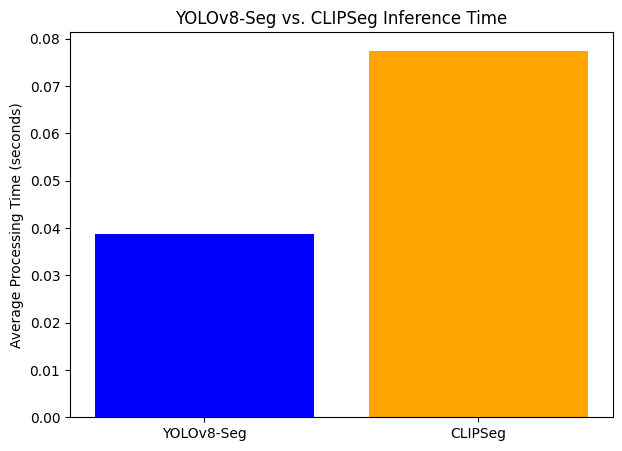

In [23]:
# Create bar chart for inference time comparison
methods = ["YOLOv8-Seg", "CLIPSeg"]
times = [avg_yolo_time, avg_clipseg_time]

plt.figure(figsize=(7, 5))
plt.bar(methods, times, color=["blue", "orange"])
plt.ylabel("Average Processing Time (seconds)")
plt.title("YOLOv8-Seg vs. CLIPSeg Inference Time")
plt.show()


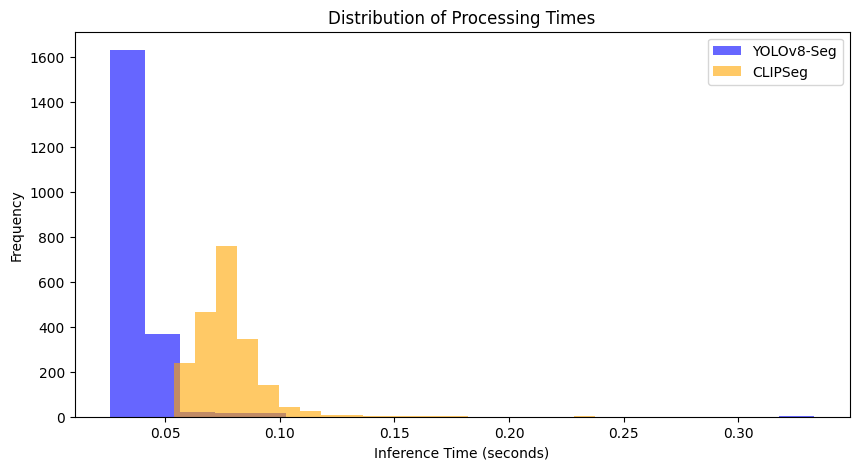

In [24]:
plt.figure(figsize=(10, 5))
plt.hist(yolo_times, bins=20, alpha=0.6, label="YOLOv8-Seg", color="blue")
plt.hist(clipseg_times, bins=20, alpha=0.6, label="CLIPSeg", color="orange")
plt.xlabel("Inference Time (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Processing Times")
plt.legend()
plt.show()
